In [1]:
from IPython.display import Image
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
%matplotlib nbagg

In [2]:
class W2vVisualizer:
    def __init__(self, ax, start_x, start_y, learning_rate):
        self.ax = ax
        self.graph_x = start_x
        self.graph_y = start_y
        self.lr = learning_rate

        sign_y = 2.8
        self.ax.text(self.graph_x + 5.2, self.graph_y + sign_y, "@", fontsize=10)
        self.ax.text(self.graph_x + 9.2, self.graph_y + sign_y + 0.2, "=", fontsize=10)
        self.ax.text(self.graph_x + 13.2, self.graph_y + sign_y, "@", fontsize=10)
        self.ax.text(self.graph_x + 19.2, self.graph_y + sign_y + 0.2, "=", fontsize=10)
        self.ax.text(self.graph_x + 7.3, self.graph_y + 14.7, "x", fontsize=10)
        self.ax.text(self.graph_x + 16.3, self.graph_y + 14.7, "x", fontsize=10)
        self.ax.text(self.graph_x + 21.5, self.graph_y + 17, "Backpropagation", fontsize=6)
        self.ax.annotate("", xy=(8, 13), xytext=(8, 9), arrowprops=dict(arrowstyle="<-"))
        self.ax.annotate("", xy=(17, 13), xytext=(17, 9), arrowprops=dict(arrowstyle="<-"))
        self.ax.annotate("", xy=(25.2, 7.5), xytext=(26.5, 7), arrowprops=dict(arrowstyle="<-"))
        self.ax.annotate("", xy=(25.2, 7.5), xytext=(26.5, 8), arrowprops=dict(arrowstyle="<-"))
        self.ax.annotate("", xy=(25.5, 14), xytext=(25.5, 18.15), arrowprops=dict(arrowstyle="-"))
        self.ax.annotate("", xy=(25.6, 18), xytext=(21, 18), arrowprops=dict(arrowstyle="<-"))

    def update(self, w_t, w_c, w2v):
        '''
            train_step = 0 # init net
            train_step = 1 # forward_pass
            train_step = 2 # update EI
            train_step = 3 # update delta
            train_step = 4 # update weight & loss
        :param w_t:
        :param w_c:
        :param w2v:
        :return:
        '''
        word = w2v.index_word[w_t.index(1)]
        context_word1 = w2v.index_word[w_c[0].index(1)]
        context_word2 = w2v.index_word[w_c[1].index(1)] if len(w_c) > 1 else ""
        self.ax.text(self.graph_x + 0, self.graph_y + 5.7, "Target word: " + word, fontsize=8)
        self.ax.text(self.graph_x + 0, self.graph_y + 6.7, "Context word 1: " + context_word1, fontsize=8)
        self.ax.text(self.graph_x + 0, self.graph_y + 7.7, "Context word 2: " + context_word2, fontsize=8)
        self.ax.text(self.graph_x + 0, self.graph_y + 8.7, "Loss: " + str(w2v.loss), fontsize=8)
        self.ax.text(self.graph_x + 0, self.graph_y + 9.7, "Iteration: " + str(w2v.iteration), fontsize=8)

        input_layer = MatrixDraw(self.ax, self.graph_x + 0, self.graph_y + 2)
        input_layer.set_data(w_t)
        input_layer.set_title('input layer (target word)')
        input_layer.draw(w2v.train_step == 0)

        weight1 = MatrixDraw(self.ax, self.graph_x + 6, self.graph_y + 0)
        weight1.set_data(w2v.w1)
        weight1.set_title('w1 (embedding result)')
        weight1.draw(w2v.train_step in [4, -1])

        hidden_layer = MatrixDraw(self.ax, graph_x + 10, self.graph_y + 2)
        hidden_layer.set_data(w2v.h)
        hidden_layer.set_title('hidden layer')
        hidden_layer.draw(w2v.train_step == 1)

        weight2 = MatrixDraw(self.ax, self.graph_x + 14, self.graph_y + 1)
        weight2.set_data(w2v.w2)
        weight2.set_title('w2')
        weight2.draw(w2v.train_step in [4, -1])

        output_layer = MatrixDraw(self.ax, self.graph_x + 20, self.graph_y + 2)
        output_layer.set_data(w2v.u)
        output_layer.set_title('output layer (u)')
        output_layer.draw(w2v.train_step == 1)

        prediction_layer = MatrixDraw(self.ax, self.graph_x + 20, self.graph_y + 5)
        prediction_layer.set_data(w2v.y_pred)
        prediction_layer.set_title('softmax (y_pred)')
        prediction_layer.draw(w2v.train_step == 1)

        context_word1 = MatrixDraw(self.ax, self.graph_x + 26.5, self.graph_y + 4)
        context_word1.set_data(w2v.context_diff[0])
        context_word1.set_title('context word 1 diff')
        context_word1.draw(w2v.train_step == 2)

        context_word2 = MatrixDraw(self.ax, self.graph_x + 26.5, self.graph_y + 6)
        context_word2.set_data(w2v.context_diff[1])
        context_word2.set_title('context word 2 diff')
        context_word2.draw(w2v.train_step == 2)

        diff_sum = MatrixDraw(self.ax, self.graph_x + 23, self.graph_y + 9)
        diff_sum.set_data(w2v.EI)
        diff_sum.set_title('sum of diff (EI)')
        diff_sum.draw(w2v.train_step == 2)

        lr1 = MatrixDraw(self.ax, self.graph_x + 6, self.graph_y + 12)
        lr1.set_data(np.array([[self.lr]]))
        lr1.set_title('Learning Rate')
        lr1.draw(w2v.train_step == 3)

        lr2 = MatrixDraw(self.ax, self.graph_x + 14, self.graph_y + 12)
        lr2.set_data(np.array([[self.lr]]))
        lr2.set_title('Learning Rate')
        lr2.draw(w2v.train_step == 3)

        delta_w1 = MatrixDraw(self.ax, self.graph_x + 6, self.graph_y + 15)
        delta_w1.set_data(w2v.dl_dw1)
        delta_w1.set_title('delta for w1')
        delta_w1.draw(w2v.train_step == 3)

        delta_w2 = MatrixDraw(self.ax, self.graph_x + 14, self.graph_y + 15)
        delta_w2.set_data(w2v.dl_dw2)
        delta_w2.set_title('delta for w2')
        delta_w2.draw(w2v.train_step == 3)

In [3]:
class MatrixDraw:
    data = np.array([])
    title = ''
    sub_title = ''

    def __init__(self, subplot, start_x, start_y, width=1, height=1):
        self.subplot = subplot
        self.x = start_x
        self.y = start_y
        self.width = width
        self.height = height
        self.font_size = 6

    def set_data(self, data):
        if len(np.array(data).shape) == 1:
            # reshape data to 2-dimentional array
            data = np.array([data])

        self.data = data

    def set_title(self, title):
        self.title = title

    def set_sub_title(self, sub_title):
        self.sub_title = sub_title

    def draw(self, show_bg_color=False):
        num_rows = self.data.shape[0]
        num_cols = self.data.shape[1]

        y = 0
        for row in range(0, num_rows):
            for col in range(0, num_cols):
                x = self.x + col * self.width
                y = self.y + row * self.height
                val = self.data[row, col]
                cell_bg_color = "#CFE2F3" if show_bg_color else "white"
                self.subplot.add_artist(plt.Rectangle(
                    (x, y), self.width, self.height, linewidth=0.4, edgecolor="black", facecolor=cell_bg_color))
                self.subplot.text(x + 0.05, y + 0.8, np.round(val, 2), fontsize=self.font_size)

        self.subplot.text(self.x, y + 1.7, self.title, fontsize=self.font_size)
        self.subplot.text(self.x, y + 2.5, self.sub_title, fontsize=self.font_size)

In [4]:
class word2vec():

    def __init__(self):
        self.n = settings['n']
        self.lr = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
        self.train_word_idx = 0
        self.train_step = -1
        self.context_diff = []
        self.iteration = 0

    def generate_training_data(self, settings, corpus):
        # Find unique word counts using dictonary
        word_counts = defaultdict(int)
        for row in corpus:
            for word in row:
                word_counts[word] += 1
        #########################################################################################################################################################
        # print(word_counts)																																	#
        # # defaultdict(<class 'int'>, {'natural': 1, 'language': 1, 'processing': 1, 'and': 2, 'machine': 1, 'learning': 1, 'is': 1, 'fun': 1, 'exciting': 1})	#
        #########################################################################################################################################################

        ## How many unique words in vocab? 9
        self.v_count = len(word_counts.keys())
        #########################
        # print(self.v_count)	#
        # 9						#
        #########################

        # Generate Lookup Dictionaries (vocab)
        self.words_list = list(word_counts.keys())
        #################################################################################################
        # print(self.words_list)																		#
        # ['natural', 'language', 'processing', 'and', 'machine', 'learning', 'is', 'fun', 'exciting']	#
        #################################################################################################

        # Generate word:index
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        #############################################################################################################################
        # print(self.word_index)																									#
        # # {'natural': 0, 'language': 1, 'processing': 2, 'and': 3, 'machine': 4, 'learning': 5, 'is': 6, 'fun': 7, 'exciting': 8}	#
        #############################################################################################################################

        # Generate index:word
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))
        #############################################################################################################################
        # print(self.index_word)																									#
        # {0: 'natural', 1: 'language', 2: 'processing', 3: 'and', 4: 'machine', 5: 'learning', 6: 'is', 7: 'fun', 8: 'exciting'}	#
        #############################################################################################################################

        training_data = []

        # Cycle through each sentence in corpus
        for sentence in corpus:
            sent_len = len(sentence)

            # Cycle through each word in sentence
            for i, word in enumerate(sentence):
                # Convert target word to one-hot
                w_target = self.word2onehot(sentence[i])

                # Cycle through context window
                w_context = []

                # Note: window_size 2 will have range of 5 values
                for j in range(i - self.window, i + self.window + 1):
                    # Criteria for context word
                    # 1. Target word cannot be context word (j != i)
                    # 2. Index must be greater or equal than 0 (j >= 0) - if not list index out of range
                    # 3. Index must be less or equal than length of sentence (j <= sent_len-1) - if not list index out of range
                    if j != i and j <= sent_len - 1 and j >= 0:
                        # Append the one-hot representation of word to w_context
                        w_context.append(self.word2onehot(sentence[j]))
                    # print(sentence[i], sentence[j])
                    #########################
                    # Example:				#
                    # natural language		#
                    # natural processing	#
                    # language natural		#
                    # language processing	#
                    # language append 		#
                    #########################

                # training_data contains a one-hot representation of the target word and context words
                #################################################################################################
                # Example:																						#
                # [Target] natural, [Context] language, [Context] processing									#
                # print(training_data)																			#
                # [[[1, 0, 0, 0, 0, 0, 0, 0, 0], [[0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]]]]	#
                #################################################################################################
                training_data.append([w_target, w_context])

        return np.array(training_data)

    def init_net(self):
        # Initialising weight matrices
        # np.random.uniform(HIGH, LOW, OUTPUT_SHAPE)
        # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.uniform.html
        # self.w1 = np.array(getW1)
        # self.w2 = np.array(getW2)
        self.w1 = np.random.uniform(-1, 1, (self.v_count, self.n))
        self.w2 = np.random.uniform(-1, 1, (self.n, self.v_count))

        self.dl_dw1 = np.zeros((self.v_count, self.n))
        self.dl_dw2 = np.zeros((self.n, self.v_count))

        self.loss = 0
        self.EI = np.zeros((1, self.v_count))
        self.context_diff = np.zeros((self.window*2, self.v_count))
        self.h = np.zeros((1, self.n))
        self.u = np.zeros((1, self.v_count))
        self.y_pred = np.zeros((1, self.v_count))

    def word2onehot(self, word):
        # word_vec - initialise a blank vector
        word_vec = [0 for i in range(0, self.v_count)]  # Alternative - np.zeros(self.v_count)
        #############################
        # print(word_vec)			#
        # [0, 0, 0, 0, 0, 0, 0, 0]	#
        #############################

        # Get ID of word from word_index
        word_index = self.word_index[word]

        # Change value from 0 to 1 according to ID of the word
        word_vec[word_index] = 1

        return word_vec

    def update_loss(self, context_word):
        self.loss += -np.sum([self.u[word.index(1)] for word in context_word]) \
                     + len(context_word) * np.log(np.sum(np.exp(self.u)))

    def update_EI(self, w_c):
        diff_sum = 0
        for (i, word) in enumerate(w_c):
            diff = np.subtract(self.y_pred, word)
            self.context_diff[i] = diff

        self.EI = np.sum(self.context_diff, axis=0)

    def train(self, training_data):
        # Cycle through each epoch
        for i in range(self.epochs):
            # Intialise loss to 0
            self.loss = 0
            # Cycle through each training sample
            # w_t = vector for target word, w_c = vectors for context words
            for w_t, w_c in training_data:
                # Forward pass
                # 1. predicted y using softmax (y_pred) 2. matrix of hidden layer (h) 3. output layer before softmax (u)
                self.forward_pass(w_t)
                #########################################
                # print("Vector for target word:", w_t)	#
                # print("W1-before backprop", self.w1)	#
                # print("W2-before backprop", self.w2)	#
                #########################################

                # Calculate error
                # 1. For a target word, calculate difference between y_pred and each of the context words
                # 2. Sum up the differences using np.sum to give us the error for this particular target word
                self.update_EI(w_c)
                #########################
                # print("Error", EI)	#
                #########################

                # Backpropagation
                # We use SGD to backpropagate errors - calculate loss on the output layer
                self.backprop(self.EI, self.h, w_t)
                #########################################
                # print("W1-after backprop", self.w1)	#
                # print("W2-after backprop", self.w2)	#
                #########################################

                # Calculate loss
                # There are 2 parts to the loss function
                # Part 1: -ve sum of all the output +
                # Part 2: length of context words * log of sum for all elements (exponential-ed) in the output layer before softmax (u)
                # Note: word.index(1) returns the index in the context word vector with value 1
                # Note: u[word.index(1)] returns the value of the output layer before softmax
                self.update_loss(w_c)

            #############################################################
            # Break if you want to see weights after first target word 	#
            # break 													#
            #############################################################
            print('Epoch:', i, "Loss:", self.loss)

    def forward_pass(self, x):
        # x is one-hot vector for target word, shape - 9x1
        # Run through first matrix (w1) to get hidden layer - 10x9 dot 9x1 gives us 10x1
        h = np.dot(x, self.w1)
        # Dot product hidden layer with second matrix (w2) - 9x10 dot 10x1 gives us 9x1
        u = np.dot(h, self.w2)
        # Run 1x9 through softmax to force each element to range of [0, 1] - 1x8
        y_c = self.softmax(u)

        self.y_pred = y_c
        self.h = h
        self.u = u

        return y_c, h, u

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def update_delta(self, e, h, x):
        self.dl_dw2 = np.outer(h, e)
        self.dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

    def update_weight(self):
        self.w1 = self.w1 - (self.lr * self.dl_dw1)
        self.w2 = self.w2 - (self.lr * self.dl_dw2)

    def backprop(self, e, h, x):
        # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.outer.html
        # Column vector EI represents row-wise sum of prediction errors across each context word for the current center word
        # Going backwards, we need to take derivative of E with respect of w2
        # h - shape 10x1, e - shape 9x1, dl_dw2 - shape 10x9
        # x - shape 9x1, w2 - 10x9, e.T - 9x1
        self.dl_dw2 = np.outer(h, e)
        self.dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
        ########################################
        # print('Delta for w2', dl_dw2)			#
        # print('Hidden layer', h)				#
        # print('np.dot', np.dot(self.w2, e.T))	#
        # print('Delta for w1', dl_dw1)			#
        #########################################

        # Update weights
        self.w1 = self.w1 - (self.lr * self.dl_dw1)
        self.w2 = self.w2 - (self.lr * self.dl_dw2)

    # Get vector from word
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w

    # Input vector, returns nearest word(s)
    def vec_sim(self, word, top_n):
        v_w1 = self.word_vec(word)
        word_sim = {}

        for i in range(self.v_count):
            # Find the similary score for each word in vocab
            v_w2 = self.w1[i]
            theta_sum = np.dot(v_w1, v_w2)
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_sum / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)

        # for word, sim in words_sorted[:top_n]:
        #     print(word, sim)

        return words_sorted

<IPython.core.display.Javascript object>


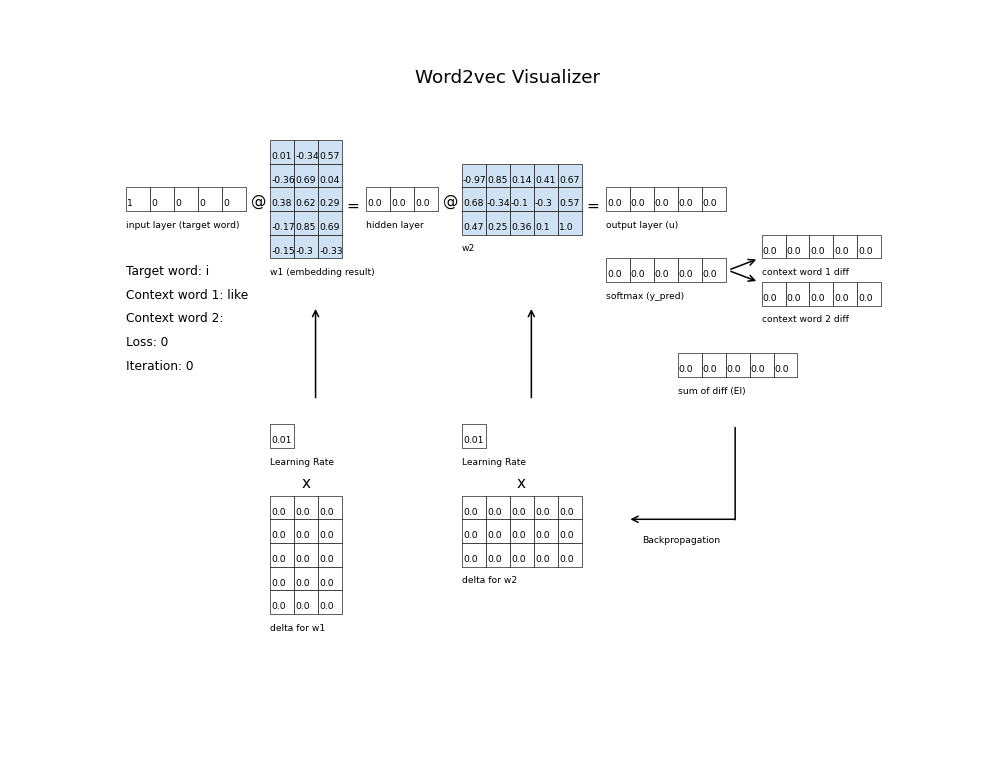

In [5]:
settings = {
    'window_size': 1,  # context window +- center word
    'n': 3,  # dimensions of word embeddings, also refer to size of hidden layer
    'epochs': 3,  # number of training epochs
    'learning_rate': 0.01  # learning rate
}
text = "i like text information systems"
corpus = [[word.lower() for word in text.split()]]

# Initialise object
w2v = word2vec()

# Numpy ndarray with one-hot representation for [target_word, context_words]
training_data = w2v.generate_training_data(settings, corpus)
w2v.init_net()

plt.rcParams["figure.figsize"] = (9, 7)
figure, axes = plt.subplots()
plt.gca().invert_yaxis()
plt.title('Word2vec Visualizer')

ax1 = plt.subplot(111)
ax1.set_xlim(0, 32)
ax1.set_ylim(0, 25)
ax1.axis('off')

graph_x = 0.1
graph_y = 2
lr = 0.01

plt.gca().invert_yaxis()
plt.title('Word2vec Visualizer')
plt.show()

def update_table(event):
    event.canvas.figure.clear()
    ax1 = plt.subplot(111)
    ax1.set_xlim(0, 32)
    ax1.set_ylim(0, 25)
    ax1.axis('off')

    if w2v.train_word_idx >= len(training_data):
        return

    w_t, w_c = training_data[w2v.train_word_idx]

    '''
    train_step = 0 # init net
    train_step = 1 # forward_pass
    train_step = 2 # update EI
    train_step = 3 # update delta
    train_step = 4 # update weight & loss
    '''
    if w2v.train_step == 1:
        w2v.forward_pass(w_t)
    if w2v.train_step == 2:
        w2v.update_EI(w_c)
    if w2v.train_step == 3:
        w2v.update_delta(w2v.EI, w2v.h, w_t)
    if w2v.train_step == 4:
        w2v.update_weight()
        w2v.update_loss(w_c)

    w2v_vis = W2vVisualizer(ax1, graph_x, graph_y, lr)
    w2v_vis.update(w_t, w_c, w2v)

    plt.gca().invert_yaxis()
    plt.title('Word2vec Visualizer')
    plt.show()

    event.canvas.draw()

    w2v.train_step += 1
    if w2v.train_step > 4:
        w2v.train_step = 0
        w2v.train_word_idx += 1
    
figure.canvas.mpl_connect('button_press_event', update_table)

update_table(figure)

# for iter in range(0, 10):
#     w2v.iteration = iter
#     for i in range(0, 1000):
#         update_table(figure)
#         time.sleep(1)
#         if w2v.train_word_idx >= len(training_data):
#             w2v.train_step = 0
#             w2v.train_word_idx = 0
#             print("Iteration {} Finish".format(iter))
#             break